# Prerequisites

Ensure you are using a Python 3.5 kernel to run this notebook.

## Setting up the streamsx.health module

For this course, you'll need the streamsx.health module. Run the cell below to install it:

In [15]:
!pip install --upgrade "git+https://github.com/IBMStreams/streamsx.health#egg=streamsx_health.ingest&subdirectory=ingest/common/python/package"

  Cloning https://github.com/IBMStreams/streamsx.health to /tmp/s98e-d29fea53683750-ad703ab2e4e9/pip-build/streamsx-health.ingest
  Found existing installation: streamsx-health.ingest 0.1
    Uninstalling streamsx-health.ingest-0.1:
      Successfully uninstalled streamsx-health.ingest-0.1
  Running setup.py install for streamsx-health.ingest ... done


## Setting up Bluemix

Open the Bluemix web portal and <a href="https://www.ibm.com/cloud-computing/bluemix/?S_PKG=&cm_mmc=Search_Google-_-Cloud_Bluemix+Program-_-WW_CA-_-bluemix_Exact_&cm_mmca1=000002FP&cm_mmca2=10001882&mkwid=48dda379-dca8-42ec-a613-5d0a00aab1e7|401|1648444&cvosrc=ppc.google.bluemix&cvo_campaign=Cloud_Bluemix%20Program-WW_CA&cvo_crid=191054889326&Matchtype=e" target="_blank" rel="noopener noreferrer">log in or sign up for a free Bluemix account</a>.

Ensure that your Streaming Analytics service is running in Bluemix.

If you don’t have a service, you can create one as follows:  
1. Click **Catalog** or **Create Service**, browse for `Streaming Analytics` and then click on it. <br>
1. Follow the instructions on the Streaming Analytics catalog page, type the *Service name* to set up your service.<br>
<img src='https://github.com/kcibm/tutorials/blob/master/OnlineCourse_IntroToPython/service%20name.PNG?raw=true' alt="Type your service name and click on Create" title="Streaming Analytics catalog - Type your service name"></img><br>
1. Click **Create** to open the Streaming Analytics service dashboard. Your service will start automatically.

<a id="setupservice"></a>
## Set up access to the service

You must provide the information that your streaming app needs to access the service.
Run the cells below to provide your service name and credentials. If you are not prompted to enter the service credentials, click **Kernel -> Restart** on the menu bar and rerun the cells.


In [16]:
service_name = input("Streaming Analytics service name:")

Streaming Analytics service name:StreamAnalyticsPython


In [17]:
import getpass
credentials=getpass.getpass('Streaming Analytics credentials:')

Streaming Analytics credentials:········


**Tip:** 
To copy your service credentials, open the Streaming Analytics service dashboard click **Service Credentials**, then **View Credentials**, and finally click the Copy icon and paste your service credentials when prompted.<br>
<img src='https://github.com/kcibm/tutorials/blob/master/OnlineCourse_IntroToPython/credentials.PNG?raw=true' alt="Copy your service credentials" title="Streaming Analytics catalog - Copy your service credentials"></img>
<br>


# Lab 1 - Create a simple Python application

## Step 1 - Develop a basic Python application

In this exercise, you will develop a simple streaming application to process sample data.

### Instructions

1. Import the necessary modules from the streamsx package. You will need:
    - the `Topology` import, from `streamsx.topology`
    - everything in the `streamsx.topology.context` module <br><br>
2. Create a function, called 'Observations'
    - Create a string `jsonStr` and assign it the sample patient data shown in the section below
    - Import the `json` module, and load the JSON data into a dictionary called `dictObj`
    - Import the `time` module and slow your source by one second
    - Yield `dictObj` with each iteration through the above code
    - Finally, to simulate a continuous source, generate the data infinitely. <br><br>
3.  Create a new topology. Then, create a new stream `patientData` from the data source you defined above.
4. Print the data stream in the console.
5. Submit the application over Bluemix.

### Sample Data

`{"patientId":"patient-1", "device":{"id":"VitalsGenerator", "locationId":"bed1"}, "readingSource":{"id":123, "deviceId":"VitalsGenerator", "sourceType":"generated"}, "reading": {"ts": 605, "uom":"bpm", "value":82.56785326532197, "readingType": {"code":"8867-4", "system":"streamsx.heath/1.0"}}}`

In [10]:
#Imports
from streamsx.topology.topology import Topology
from streamsx.topology.context import * 
import json
import time

#Set up access to Streaming Analytics service
vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (credentials)}]}
cfg = {}
cfg[ConfigParams.VCAP_SERVICES] = vs
cfg[ConfigParams.SERVICE_NAME] = service_name

# Define data source
def observations():
    while True:
        jsonstr =  '{"patientId":"patient-1", "device":{"id":"VitalsGenerator", "locationId":"bed1"}, "readingSource":{"id":123, "deviceId":"VitalsGenerator", "sourceType":"generated"}, "reading": {"ts": 605, "uom":"bpm", "value":82.56785326532197, "readingType": {"code":"8867-4", "system":"streamsx.heath/1.0"}}}'        
        dictobj = json.loads(jsonstr)
        time.sleep(1)
        yield(dictobj)
        
# Create Topology and read from data source 

topo = Topology()
patientData = topo.source(observations)


# Print
patientData.sink(print)

# Submit on Bluemix
submit('STREAMING_ANALYTICS_SERVICE', topo, cfg)

Nov 16, 2017 11:32:40 PM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): Checking status
Nov 16, 2017 11:32:46 PM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (StreamAnalyticsPython): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Nov 16, 2017 11:32:46 PM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting build module_6B69A8E858B7D53D
Nov 16, 2017 11:33:36 PM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting job request.
Nov 16, 2017 11:33:42 PM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWr

# Lab 2 - Handle a diversity of patient data

## Step 1 - Filter data using lambda function

In this exercise, you will modify the application to only handle heart rate from the patient readings.

1.  Filter out all the readings whose `code` value is not '8867-4'. Assign the name `heartRate` to the filtered stream. 
2.  Fix the `sink()` function to sink the `heartRate` stream instead.
3.  Submit the application over Bluemix and view the output on your Streams Console.

## Step 2 - Submit the patient simulator job

1. On the Streams Console, click the 'Submit Job' button
2.  Leave the instance field as its default value
3.  Select 'Specify the URL of the application bundle' and enter the following URL:
    https://github.com/IBMStreams/streamsx.health/releases/download/v0.1/com.ibm.streamsx.health.simulate.beacon.services.HealthDataBeaconService.sab
4. Click 'Submit.'<br>
    
## Step 3 - Subscribe to the simulator
1.  Import the `schema` module from `streamsx.topology`.
2. Replace your `Observations` source with a Subscribe call to the patient simulator. The topic to subscribe to is `'ingest-beacon'`.
3.  Make sure the simulator is running before you submit any subsequent applications.
4.  Submit your application over Bluemix and view the output.

In [20]:
#Imports
from streamsx.topology.topology import Topology
from streamsx.topology.context import * 
from streamsx.topology import schema 

import json
import time

#Set up access to Streaming Analytics service
vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (credentials)}]}
cfg = {}
cfg[ConfigParams.VCAP_SERVICES] = vs
cfg[ConfigParams.SERVICE_NAME] = service_name

# Define data source
'''def observations():
    while True:
        jsonstr =  '{"patientId":"patient-1", "device":{"id":"VitalsGenerator", "locationId":"bed1"}, "readingSource":{"id":123, "deviceId":"VitalsGenerator", "sourceType":"generated"}, "reading": {"ts": 605, "uom":"bpm", "value":82.56785326532197, "readingType": {"code":"8867-4", "system":"streamsx.heath/1.0"}}}'        
        dictobj = json.loads(jsonstr)
        time.sleep(1)
        yield(dictobj)'''
        
# Create Topology and read from data source 

topo = Topology()
patientData = topo.subscribe('ingest-beacon', schema.CommonSchema.Json)
heartRate = patientData.filter(lambda x: (x['reading']['readingType']['code']=='8867-4'))



# Print
heartRate.sink(print)

# Submit on Bluemix
submit('STREAMING_ANALYTICS_SERVICE', topo, cfg)

Nov 17, 2017 1:15:55 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): Checking status
Nov 17, 2017 1:16:00 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (StreamAnalyticsPython): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Nov 17, 2017 1:16:00 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting build module_AE1A17AF25425805
Nov 17, 2017 1:17:28 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting job request.
Nov 17, 2017 1:17:38 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper

# Lab 3 - Anonymize and average data 

## Step 1 - Anonymize Patient Data

In this exercise, you are going to 'anonymize' patient data by hashing identifying information.

1. Import the `hashlib` module
2. Make a function that...
    * Has a single parameter
    * Hashes `patientId` and `locationId` using the sha256() algorithm<br>
    You can use: `ITEM_TO_ENCODE = hashlib.sha256(ITEM_TO_ENCODE.encode('utf-8')).digest()`<br>
    * Returns the modified tuple 
3.  Modify the content of each tuple on the `patientData` stream by calling the anonymize method. Name the new stream `patientX.` This step should precede the filter.
4.  Submit over Bluemix and view the output.

## Step 2 - Keeping States

In this exercise, you will keep state of the last 10 tuples from the patient data stream. For each new tuple that comes in, you will calculate the moving average from the last 10 tuples.

1. Import the `getReadingValue` function from the `streamsx_health.ingest.Observation` module.
2. Create a new callable class.  The class should have a field called `last_n`, which is a list that keeps track of the last n tuples.
    *  The \__call\__ method of the class should take a single parameter, `n`, which is the number of tuples over which to calculate the average
    * When the \__call\__ method is called, append the tuple's heart rate reading to the list.  If the length of the list > `n`, pop the oldest tuple.
    * Return the average of all values from the list<br><br>
2.  Calculate the moving average of heart rate, over the last 10 tuples, calling the new stream `avgHr`
3. Submit the application over Bluemix, and view the results - a simple list of average heart rate readings.


In [25]:
#Imports
from streamsx.topology.topology import Topology
from streamsx.topology.context import * 
from streamsx.topology import schema 
from streamsx_health.ingest.Observation import getReadingValue

import hashlib
import json
import time

#Set up access to Streaming Analytics service
vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (credentials)}]}
cfg = {}
cfg[ConfigParams.VCAP_SERVICES] = vs
cfg[ConfigParams.SERVICE_NAME] = service_name

# Define data source
'''def observations():
    while True:
        jsonstr =  '{"patientId":"patient-1", "device":{"id":"VitalsGenerator", "locationId":"bed1"}, "readingSource":{"id":123, "deviceId":"VitalsGenerator", "sourceType":"generated"}, "reading": {"ts": 605, "uom":"bpm", "value":82.56785326532197, "readingType": {"code":"8867-4", "system":"streamsx.heath/1.0"}}}'        
        dictobj = json.loads(jsonstr)
        time.sleep(1)
        yield(dictobj)'''
        


# Create Topology and read from data source 
topo = Topology()

#Subscribe
patientData = topo.subscribe('ingest-beacon', schema.CommonSchema.Json)

#last 10 readings

class Avg:
    def __init__(self, n):
        self.n = n
        self.last_n = []
        
    def __call__(self, tup):
        self.last_n.append(getReadingValue(tup))
        if (len(self.last_n) > self.n):
            self.last_n.pop(0)
        return sum(self.last_n) / len(self.last_n)
            
    
    
## Anonymize
def anonymize(tup):
    tup["patientId"] = hashlib.sha256(tup["patientId"].encode('utf-8')).digest()
    tup["device"]["locationId"] = hashlib.sha256(tup["device"]["locationId"].encode('utf-8')).digest()
    return tup

patientX = patientData.map(anonymize)

#Filter
heartRate = patientX.filter(lambda tup: (tup['reading']['readingType']['code']=='8867-4'))

#avg heartrate stream
avgHr = heartRate.map(Avg(10))

# Print
avgHr.sink(print)

# Submit on Bluemix
submit('STREAMING_ANALYTICS_SERVICE', topo, cfg)

Nov 17, 2017 2:37:43 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): Checking status
Nov 17, 2017 2:37:48 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (StreamAnalyticsPython): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Nov 17, 2017 2:37:48 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting build module_3B4798FF499200E1
Nov 17, 2017 2:38:39 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting job request.
Nov 17, 2017 2:38:45 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper

# Lab 4 - Visualize data in Python notebook

## Step 1 - Viewing Data

1. Before the print statement, create a view from the Average Heart Rate stream.
2.  Launch the application and proceed to the cells below.
  

In [26]:
#Imports
from streamsx.topology.topology import Topology
from streamsx.topology.context import * 
from streamsx.topology import schema 
from streamsx_health.ingest.Observation import getReadingValue

import hashlib
import json
import time

#Set up access to Streaming Analytics service
vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (credentials)}]}
cfg = {}
cfg[ConfigParams.VCAP_SERVICES] = vs
cfg[ConfigParams.SERVICE_NAME] = service_name

# Define data source
'''def observations():
    while True:
        jsonstr =  '{"patientId":"patient-1", "device":{"id":"VitalsGenerator", "locationId":"bed1"}, "readingSource":{"id":123, "deviceId":"VitalsGenerator", "sourceType":"generated"}, "reading": {"ts": 605, "uom":"bpm", "value":82.56785326532197, "readingType": {"code":"8867-4", "system":"streamsx.heath/1.0"}}}'        
        dictobj = json.loads(jsonstr)
        time.sleep(1)
        yield(dictobj)'''


# Create Topology and read from data source 
topo = Topology()

#Subscribe
patientData = topo.subscribe('ingest-beacon', schema.CommonSchema.Json)
    
## Anonymize
def anonymize(tup):
    tup["patientId"] = hashlib.sha256(tup["patientId"].encode('utf-8')).digest()
    tup["device"]["locationId"] = hashlib.sha256(tup["device"]["locationId"].encode('utf-8')).digest()
    return tup

patientX = patientData.map(anonymize)

#Filter
heartRate = patientX.filter(lambda tup: (tup['reading']['readingType']['code']=='8867-4'))


#last 10 readings
class Avg:
    def __init__(self, n):
        self.n = n
        self.last_n = []
        
    def __call__(self, tup):
        self.last_n.append(getReadingValue(tup))
        if (len(self.last_n) > self.n):
            self.last_n.pop(0)
        return sum(self.last_n) / len(self.last_n)

#avg heartrate stream
avgHr = heartRate.map(Avg(10))

#view data
avgHrView = avgHr.view()

# Print
avgHr.sink(print)

# Submit on Bluemix
submit('STREAMING_ANALYTICS_SERVICE', topo, cfg)

Nov 17, 2017 2:52:29 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): Checking status
Nov 17, 2017 2:52:34 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (StreamAnalyticsPython): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Nov 17, 2017 2:52:34 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting build module_B60A167E3F06FA6D
Nov 17, 2017 2:53:38 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (StreamAnalyticsPython): submitting job request.
Nov 17, 2017 2:53:45 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper

## Step 2a - Fetch View Data

The following code shows how to fetch view data from a view that we have set up in a Streams application.

1.  Import `deque` from the collections module. 
2. Create a deque called `plotQueue` that holds up to 2000 tuples.
3. Start fetching data for your view.
4. Create a `data_collector` function that iterates through your view data and appends each value to `plotQueue`.
5.  Run `data_collector` in a background thread and save data in `plotQueue` - `plotQueue` will be used to visualize data in the next cell.

In [27]:
#Imports
from collections import deque
from IPython.lib import backgroundjobs as bg

# Create a buffer of 2000 tuples for plotting
plotQueue = deque([], 2000)

#Fetch view data
view = avgHrView.start_data_fetch()

#Define data collector function
def data_collecter(view):
    for d in iter(view.get, None):
        plotQueue.append(float(d)) 

#Start a background thread and save view data in deque
jobs = bg.BackgroundJobManager()
jobs.new(data_collecter, view)


Starting job # 0 in a separate thread.


<BackgroundJob #0: <function data_collecter at 0x7f52a9a292f0>>

## Step 2b - Visualize View Data using Matplotlib

The following cell shows how to view realtime data in Jupyter Notebook.
The code updates the view once every second.  
Data is plotted from the `plotQueue` variable.

As long as the data view and the view is running, you can start and stop the following cell when you work on your analytics and visualizations.

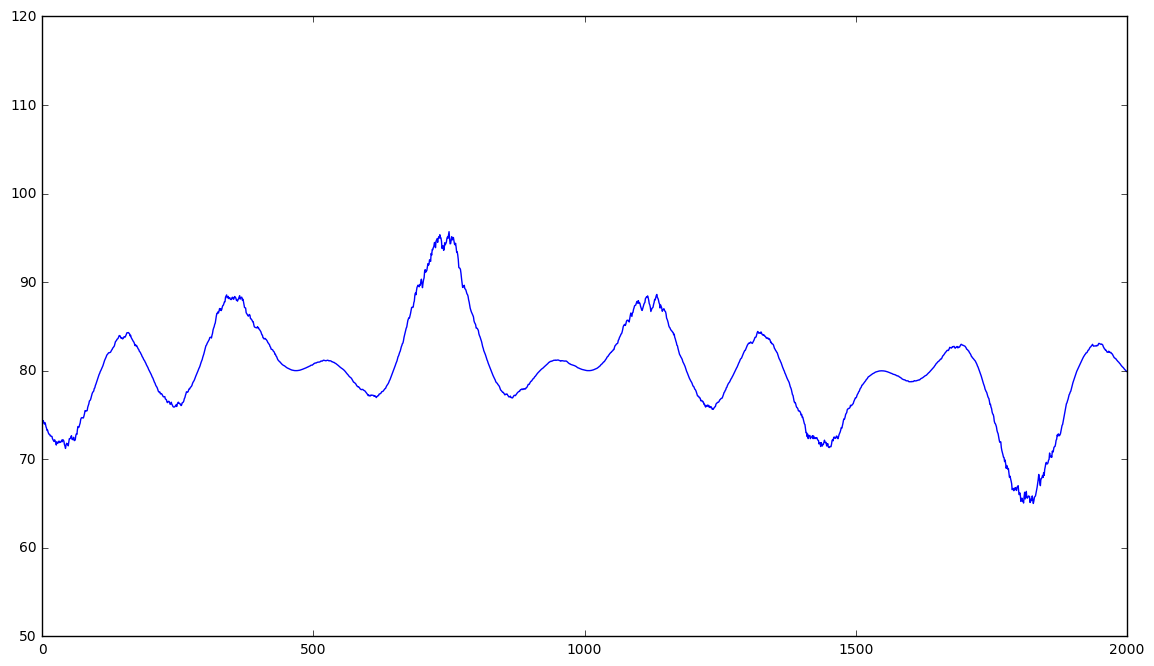

2000


In [ ]:
# Visualize view data in a line graph
%matplotlib inline
import time
from IPython import display
import pylab as pl

pl.rcParams['figure.figsize'] = (14.0, 8.0)

while (True):
    pl.clf()
    ax = pl.gca()
    ax.set_autoscale_on(False)
    ax.plot(plotQueue)
    ax.axis([0, 2000, 50, 120])
    display.display(pl.gcf())
    print(len(plotQueue))
    display.clear_output(wait=True)
    time.sleep(1.0)
